In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb

In [46]:
df = pd.read_csv('data.csv')
print(df.shape)
df.head()

(1332, 12)


,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,S_rad_mean,S_hot,C_sum,C_rad_mean,C_hot,dist2charge,label
0,1,4,5,1800.534376,940.830078,1.029599,0.275822,1335.482056,1.045024,0.350993,56.019219,2
1,1,6,5,8846.113024,1004.029785,1.409577,0.188146,3485.240479,1.588097,0.276602,87.007090,2
2,1,3,5,1536.473341,1051.808228,1.191492,0.250219,795.982666,1.062965,0.233333,50.515221,2
3,2,8,5,9909.289630,1245.740112,1.459897,0.245276,4685.632812,1.263931,0.334092,401.636652,2
4,4,10,4,2431.929683,1607.251709,1.202339,0.190084,2237.596436,1.326049,0.221344,76.160312,2


In [44]:
# train test split by eventId!
id_train, id_test = train_test_split(df.eventId.values,
                                     test_size=0.3, 
                                     random_state=42,
                                     stratify=df.PrimaryDecayMode.values)
print(id_train.shape, id_test.shape)

(932,) (400,)


In [29]:
excl_columns = ['PrimaryDecayMode', 'clusterId', 'VecShowerEnergy', 'label']

# train dataset
df_train = df[df.eventId.isin(id_train)].drop(['eventId'], axis=1)
y_train = df_train.label.values
z_train = df_train.VecShowerEnergy.values
df_train.drop(excl_columns, inplace=True, axis=1)
X_train = df_train.values
train_data = lgb.Dataset(X_train, label=y_train)

# test data set
df_test = df[df.eventId.isin(id_test)].drop(['eventId'], axis=1)
y_test = df_test.label.values
z_test = df_test.VecShowerEnergy.values
id_test = df_test.clusterId.values.reshape([-1,1])
df_test.drop(excl_columns, inplace=True, axis=1)
X_test = df_test.values
test_data = lgb.Dataset(X_test, label=y_test)

### Plot features

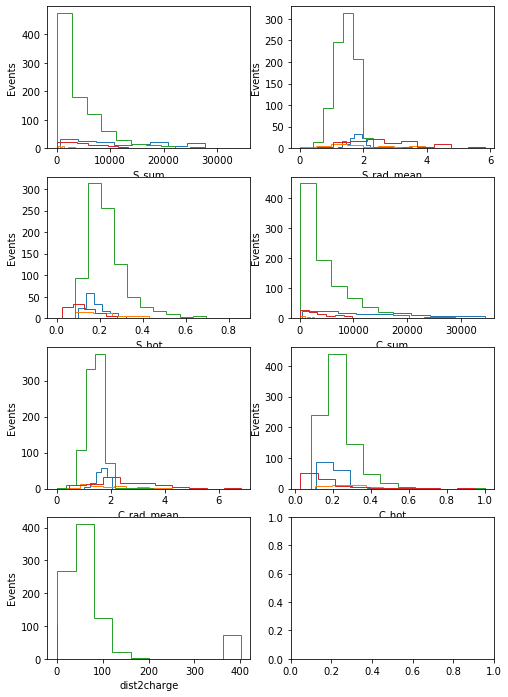

In [73]:
xtitle = df_train.columns
fig, ax = plt.subplots(4, 2, figsize=(8,12))
for i in range(X_train.shape[1]):
    for j in np.unique(y_train):
        h = ax[i//2][i%2].hist(X_train[:,i][y_train==j], histtype='step')
        ax[i//2][i%2].set_xlabel(xtitle[i])
        ax[i//2][i%2].set_ylabel(f"Events") # / {binwidth}")

# Classification

(Boosted) decision trees 'unaffected' by feature scaling

### Training

In [30]:
params = {
    'num_class': 4,
    'application': 'multiclass',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
}

In [ ]:
cv_result_lgb = lgb.cv(params,
                       train_data,
                       num_boost_round=500,
                       early_stopping_rounds=20,
                       verbose_eval=1)

### Testing

In [164]:
y_pred = np.argmax(model.predict(X_test), axis=1).reshape([-1,1])

In [91]:
confusion_matrix(y_test, y_pred)

array([[ 33,   0,   0,   2],
       [  0,  10,   0,   4],
       [  0,   0, 154,   0],
       [  0,   0,   0,  18]])

In [99]:
df_new = pd.DataFrame(np.hstack((id_test, y_pred)), columns=['clusterId', 'predictedLabel'])
df_merged = df.merge(df_new, how='inner', on='clusterId')
df_merged.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,S_rad_mean,S_hot,C_sum,C_rad_mean,C_hot,dist2charge,label,predictedLabel
0,48,117,4,27145.152914,21314.076172,2.100422,0.109939,23976.773438,1.978385,0.136850,38.708239,3,3
1,61,158,4,2803.146925,1603.018311,1.664667,0.108840,1857.292969,1.490503,0.152381,66.105149,3,3
2,61,161,4,10922.210278,8050.244141,1.966331,0.115087,8720.432617,2.006596,0.110548,50.164319,3,3
3,62,166,4,10361.459420,7399.282227,1.627021,0.202144,8136.710938,1.680261,0.186957,68.603123,3,3
4,62,165,4,7246.747640,1847.577271,0.756551,0.535721,272.964966,0.877988,0.571399,0.000000,4,4


## Regression

### Training

### Testing

## Decay classification

In [175]:
def decayClassification(x):
    counts = x.predictedLabel.value_counts()
    mode = np.nan
    if 1 in counts.keys():
        mode = 1
    elif 2 in counts.keys():
        mode = 2
    elif 4 in counts.keys():
        mode = 3
        if 3 in counts.keys():
            if counts[3] == 2:
                mode = 4
            elif counts[3] == 4:
                mode = 5
    x['predictedPrimaryDecayMode'] = mode
    return x

In [180]:
df_merged = df_merged.groupby('eventId').apply(decayClassification)

In [181]:
confusion_matrix = pd.crosstab(df_merged.PrimaryDecayMode, df_merged.predictedPrimaryDecayMode, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  1.0  2.0  3.0  4.0  5.0
Actual                            
1           33    0    2    0    0
2            0   10    4    0    0
3            0    0    3    0    0
4            0    0    7   18    0
5            0    0   16    0    5
